In [36]:
import numpy as np
from scipy import stats
import math
from math import floor
import argparse
import matplotlib.pyplot as plt
import os
import csv
#import pymc as pm
import arviz as az
import warnings
import pandas as pd 
import stan
import nest_asyncio
nest_asyncio.apply()
import seaborn as sns
import random


# globals
g_y = []
g_y_pred = []
g_num_groups = 0
g_users = [] # model users
s_users = [] # simulated users

class Simulation:

    ## Fixed hyperparameters
    initial_users = 20
    initial_groups = 6
    initial_communities = 5

    # group and community preferences
    alpha_group_hyperparameter = 10
    beta_group_hyperparameter = 10 

    alpha_community_hyperparameter = 10
    beta_community_hyperparameter = 10

    comments_per_step = 2

        
    # Initialize lists to store users and groups
    users = []
    groups = []
    communities = []


    gis = {}
    cis = {}
    uis = {}

    def __init__(self, num_timesteps, user_growth_rate, interaction_threshold, new_group_rate, new_community_rate) -> None:

        self.num_timesteps = num_timesteps

        self.user_growth_rate = user_growth_rate

        self.interaction_threshold = interaction_threshold

        self.new_group_rate = new_group_rate
        self.new_group_join_chance = new_group_rate / 10

        self.new_community_rate = new_community_rate
        self.new_community_join_chance = new_community_rate / 10

        self.same_community_interaction_ratio = new_community_rate * new_group_rate

    class Community:
        def __init__(self, simulation, group=None):
            self.simulation = simulation 
            # Initialize a community with a list of users and groups
            self.id = len(self.simulation.communities) + 1
            self.groups = [group] if group else []
            self.interactions = []

    class Group:
        def __init__(self, simulation):
            self.simulation = simulation 
            # Initialize a group with an ID and a dictionary tgo track user interactions
            self.id = len(self.simulation.groups)
            self.interactions = {}
            self.community = None

        def join_community(self, community):
            community.groups.append(self)
            self.community = community

    class User:
        def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
            # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
            self.id = None

            self.groups = []
            self.communities = []
            self.interaction_history = []

            self.group_preferences = stats.beta(group_alpha, group_beta)
            self.community_preferences = stats.beta(community_alpha, community_beta)
            self.updated_preferences = np.array([1])

        def update_preferences(self):
            # Update user's preferences based on group interactions
            if not self.groups:
                self.updated_preferences = np.array([1])
                return
            else:
                #sort groups by number of interactions
                self.groups.sort(key=lambda group: len(group.interactions))

            total_size = sum([len(group.interactions) for group in self.groups])

            # if size is 0, this must be the first iteration, return uniform
            if total_size == 0:
                self.ccdf = np.array([1])
                return
            else:
                sizes = sorted([len(group.interactions) for group in self.groups])
                self.ccdf = 1 - (np.cumsum(sizes) / total_size)

            group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

            self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

            if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
                self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
            else:
                self.updated_preferences /= np.sum(self.updated_preferences)

        def join_group(self, group):
            # Add a group to the user's group list and set initial interactions to 0
            self.groups.append(group)
            group.interactions[self] = 0

        def interact(self, group):
            # Record an interaction with the specified group
            group.interactions[self] = group.interactions.get(self, 0) + 1
            self.interaction_history.append(group.id)
            # if group.id == 0:
            #     print("A", self.interaction_history[-1])

    # Recalculate probabilities at every iteration or after any changes
    def calculate_probabilities(self):
        global community_relative_frequency, group_relative_frequency

        community_relative_frequency = np.array([len(community.groups) for community in self.communities], dtype=float)
        # if community_relative_frequency.sum() != 0:
        community_relative_frequency += 1e-5  # Avoid division by zero
        community_relative_frequency /= community_relative_frequency.sum()

        group_relative_frequency = np.array([sum(group.interactions.values()) for group in self.groups], dtype=float)
        # if group_relative_frequency.sum() != 0:
        group_relative_frequency += 1e-5
        group_relative_frequency /= group_relative_frequency.sum()


    def initialize(self):

        # Initialize users
        for i in range(self.initial_users):
            self.users.append(
                self.User(
                    self.alpha_group_hyperparameter,
                    self.beta_group_hyperparameter,
                    self.alpha_community_hyperparameter,
                    self.beta_community_hyperparameter,
                )
            )
            self.users[-1].id = len(self.users)

        # Initialize communities
        for i in range(self.initial_communities):
            self.communities.append(self.Community(self))

        # Initialize groups
        for i in range(self.initial_groups):
            self.groups.append(self.Group(self))

        # adding the first groups to each community so there is at least one group in each community
        for i in range(len(self.communities)):
            self.groups[i].join_community(self.communities[i])
            # random chance for each user to join the first group of a new community
            for user in self.users:
                if np.random.random() < self.new_community_join_chance:
                    user.join_group(self.groups[i])

        # randomly adding the rest of the groups to communities
        for group in self.groups[len(self.communities):]:
            group.join_community(self.communities[np.random.randint(0, len(self.communities))])
            for user in self.users:
                if np.random.random() < self.new_group_join_chance:
                    user.join_group(group)

        # initialize dictionaries for each group, community, and user
        for group in self.groups:
            self.gis[group.id] = []
        for community in self.communities:
            self.cis[community.id] = []
        for user in self.users:
            self.uis[user.id] = []

        
    def run(self):
        global s_users
        # main loop
        for time in range(self.num_timesteps):
            # if time % 10 == 0:
            #     print(f"Step: {time}", end = "\r")
            # Calculate probabilities
            self.calculate_probabilities()

            # Add new users
            new_users_count = floor(np.random.exponential(self.user_growth_rate))
            for i in range(new_users_count):
                self.users.append(
                    self.User(
                        self.alpha_group_hyperparameter,
                        self.beta_group_hyperparameter,
                        self.alpha_community_hyperparameter,
                        self.beta_community_hyperparameter,
                    )
                )
                self.users[-1].id = len(self.users)

            # Add new groups
            new_groups_count = floor(np.random.exponential(self.new_group_rate))
            for i in range(new_groups_count):
                self.groups.append(self.Group(self))

                # a new community always get made on the first time step
                if time == 0:
                    if new_groups_count == 0:
                        self.groups.append(self.Group(self))
                    self.groups[-1].join_community(self.communities[-1])
                    self.communities[-1].groups.append(self.groups[-1])
                else:
                    # check if the new group forms a new community
                    if np.random.random() < self.new_community_rate:
                        self.communities.append(self.Community(self, self.groups[-1]))
                        self.groups[-1].community = self.communities[-1]
                        # each user has a chance to join the new community
                        for user in self.users:
                            if np.random.random() < self.new_community_join_chance:
                                user.join_group(self.groups[-1])
                        # users[np.random.randint(0, len(users))].join_group(groups[-1])
                    else:
                        # join a random community
                        self.groups[-1].join_community(self.communities[np.random.randint(0, len(self.communities))])

            # Updating dictionaries with new groups, communities, and users
            # and setting their initial values to 0
            for group in self.groups:
                if group.id not in self.gis:
                    self.gis[group.id] = [0]
                self.gis[group.id].append(0)
            for community in self.communities:
                if community.id not in self.cis:
                    self.cis[community.id] = [0]
                self.cis[community.id].append(0)
            for user in self.users:
                if user.id not in self.uis:
                    self.uis[user.id] = [0]
                self.uis[user.id].append(0)

            # Add new users to groups
            for user in self.users:
                self.calculate_probabilities()
                # if there are groups for the user to join that they aren't in
                # if a user is not in any group, they are guaranteed to join a group
                if len(user.groups) == 0:
                    user.join_group(self.groups[np.random.choice(len(self.groups), p=group_relative_frequency)])
                else:
                    if len(user.groups) < len(self.groups):
                        # join a group
                        if np.random.random() < self.new_group_join_chance:
                            user.join_group(self.groups[np.random.choice(len(self.groups), p=group_relative_frequency)])

            # Interact with groups
            for user in self.users:
                for _ in range(self.comments_per_step):
                    user.update_preferences()
                    interacted_groups = []
                    if np.random.uniform() < self.interaction_threshold and user.groups:
                        # print(user.updated_preferences)
                        group = np.random.choice(user.groups, p=user.updated_preferences)
                        # if group.id == 0:
                        #     print("Group 0")
                        user.interact(group)
                        self.gis[group.id][-1] += 1
                        self.cis[group.community.id][-1] += 1
                        self.uis[user.id][-1] += 1

                        # potential bonus interactions within another group in the same community
                        if group.community:
                            while True:
                                if np.random.uniform() < self.same_community_interaction_ratio:
                                    community = group.community                    
                                    group = np.random.choice(community.groups)
                                    user.interact(group)
                                    self.gis[group.id][-1] += 1
                                    self.cis[group.community.id][-1] += 1
                                    self.uis[user.id][-1] += 1
                                else:
                                    break

            # Update user preferences
            for user in self.users:
                if user.groups:
                    user.update_preferences()
                    if user.id == 0:
                        print(user.updated_preferences)
                        print(user.group_preferences.pdf(np.linspace(0, 1, len(user.groups))))
                else:
                    user.updated_preferences = np.array([1])

    def plot(self, sim_number):        
        directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
        os.makedirs(directory_name, exist_ok=True)

        c_sum = []
        c_sum_labels = []
        for i in range(len(self.communities)):
            temp_sum = [0] * self.num_timesteps
            c_vals = np.cumsum(self.cis[i+1])
            # add the values starting from the back
            for j, val in enumerate(reversed(c_vals)):
                temp_sum[-1-j] = val
            c_sum.append(temp_sum)
            c_sum_labels.append(list(self.cis.keys())[i])

        # print the final value for each community
        for c in c_sum_labels[:5]:
            print(c, c_sum[c_sum_labels.index(c)][-1])
            
        # finding the labels for the 5 largest communities
        top_5 = []
        top_5_labels = []
        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(c_sum)):
                if c_sum[j][-1] > max_val and c_sum_labels[j] not in top_5_labels:
                    max_val = c_sum[j][-1]
                    max_index = j
            top_5.append(c_sum[max_index])
            top_5_labels.append(c_sum_labels[max_index])

        for i in range(len(c_sum)):
            if c_sum_labels[i] in top_5_labels:
                plt.plot(c_sum[i][:len(c_sum[i])], label=f"C{i+1}")
            else:
                plt.plot(c_sum[i][:len(c_sum[i])], label=None)

        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Interactions")
        plt.yscale("log")
        plt.title("Cumulative Interactions of Each Community Over Time")
        plt.savefig(f"{directory_name}/community_interaction_growth.png")
        plt.close()
        
        # Scatter plot for final amount of interactions for each community
        c_sum_final = []
        c_sum_final_labels = []
        for i in range(len(self.communities)):
            c_sum_final.append(c_sum[i][-1])
            c_sum_final_labels.append(list(self.cis.keys())[i])

        plt.scatter(c_sum_final_labels, c_sum_final)
        plt.xlabel("Community")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Final Cumulative Interactions of Each Community")
        plt.savefig(f"{directory_name}/final_community_interactions.png")
        plt.close()
        

        g_sum = []
        g_sum_labels = []
        for i in range(1, len(self.groups)):
            temp_sum = [0] * self.num_timesteps
            g_vals = np.cumsum(self.gis[i])
            # add the values starting from the back
            for j, val in enumerate(reversed(g_vals)):
                try:
                    temp_sum[j] = val
                except:
                    pass

            temp_sum = temp_sum[::-1]
            g_sum.append(temp_sum)
            g_sum_labels.append(list(self.gis.keys())[i])

        # print the final value for each group
        for g in g_sum_labels[:5]:
            print(g, g_sum[g_sum_labels.index(g)][-1])

        # finding the labels for the 5 largest groups
        top_5 = []
        top_5_labels = []
        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(g_sum)):
                if g_sum[j][-1] > max_val and g_sum_labels[j] not in top_5_labels:
                    max_val = g_sum[j][-1]
                    max_index = j
            top_5.append(g_sum[max_index])
            top_5_labels.append(g_sum_labels[max_index])

        for i in range(len(g_sum)):
            if g_sum_labels[i] in top_5_labels:
                plt.plot(g_sum[i], label=f"G{i+1}")
            else:
                plt.plot(g_sum[i], label=None)

        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Interactions")
        # plt.yscale("log")
        plt.ylim(bottom=1)
        plt.title("Cumulative Interactions of Each Group Over Time")
        plt.savefig(f"{directory_name}/group_interaction_growth.png")
        plt.close()

        # Scatter plot for final amount of interactions for each group
        g_sum_final = []
        g_sum_final_labels = []
        for i in range(len(g_sum)):
            g_sum_final.append(g_sum[i][-1])
            g_sum_final_labels.append(list(self.gis.keys())[i])

        plt.scatter(g_sum_final_labels, g_sum_final)
        plt.xlabel("Group")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Final Cumulative Interactions of Each Group")
        plt.savefig(f"{directory_name}/final_group_interactions.png")
        plt.close()

        for u in self.uis:
            self.uis[u] = self.uis[u][:self.num_timesteps]

        # plotting total amount of interactions for each user
        u_sum = []
        u_sum_labels = []
        for i in range(1, len(self.users)):
            temp_sum = [0] * self.num_timesteps
            u_vals = np.cumsum(self.uis[i])
            # add the values starting from the back
            for j, val in enumerate(reversed(u_vals)):
                temp_sum[j] = val

            temp_sum = temp_sum[::-1]
            u_sum.append(temp_sum)
            u_sum_labels.append(list(self.uis.keys())[i])

        # print the final value for each user
        for u in u_sum_labels[:5]:
            print(u, u_sum[u_sum_labels.index(u)][-1])

        # finding the labels for the 5 largest users
        top_5 = []
        top_5_labels = []

        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(u_sum)):
                if u_sum[j][-1] > max_val and u_sum_labels[j] not in top_5_labels:
                    max_val = u_sum[j][-1]
                    max_index = j
            top_5.append(u_sum[max_index])
            top_5_labels.append(u_sum_labels[max_index])

        # Scatter plot for final amount of interactions for each user
        u_sum_final = []
        u_sum_final_labels = []
        for i in range(len(u_sum)):
            u_sum_final.append(u_sum[i][-1])
            u_sum_final_labels.append(list(self.uis.keys())[i])

        plt.scatter(u_sum_final_labels, u_sum_final)
        plt.xlabel("User")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Cumulative Interactions of Each User")
        plt.savefig(f"{directory_name}/final_user_interactions.png")
        plt.close()

    
    def write_data(self, sim_number):
        directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
        os.makedirs(directory_name, exist_ok=True)

        # Write User Interactions to CSV
        with open(f"{directory_name}/user_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in range(1, 1 + len(list(self.uis.keys()))):
                writer.writerow([row] + [0 for _ in range(self.num_timesteps-len(self.uis[row])) ] + self.uis[row])

            file.close()
        
        # Write Group Interactions to CSV
        with open(f"{directory_name}/group_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in range(len(list(self.gis.keys()))):
                writer.writerow([row] + [0 for _ in range(self.num_timesteps-len(self.gis[row])) ] + self.gis[row])

            file.close()

        # Write Community Interactions to CSV
        with open(f"{directory_name}/community_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in range(1, 1 + len(list(self.cis.keys()))):
                writer.writerow([row] + [0 for _ in range(self.num_timesteps-len(self.cis[row])) ] + self.cis[row])

            file.close()


        with open(f"{directory_name}/simulation_data.csv", 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['num_users', 'num_groups', 'num_communities', 'num_interactions'])
            writer.writerow([len(self.users), len(self.groups), len(self.communities), sum([len(group.interactions) for group in self.groups])])

            file.close()

        print("Data written to CSV files.")

    def community_regression_model(self):

        y = []
        X = pd.DataFrame()
        g_sum = 0


        for community in range(len(self.communities)):
            df = pd.DataFrame(self.gis[community + 1]) 
            df.fillna(0, inplace=True)
            if len(df)<self.num_timesteps:
                df = df.reindex(range(self.num_timesteps), fill_value=0)
            X[community] = df.squeeze()  

        
        y=X.iloc[-1:, :].values
        
        X = X.iloc[0:99,:]

        print(type(X))
        y = y[0]
    
        print(y)
        print(type(y))
        X= X.T
        X = X.to_numpy()
        print(X)
        rows, cols = np.shape(X)
        print(rows)
        print(cols)

        

        prior_predictive ="""

        data {
            int<lower = 0> N;
            int<lower = 0> K;
            matrix[K,N]X; // group matrix

            }
        generated quantities {
            real alpha = normal_rng(0, 1);
            real beta = normal_rng(0, 1);
            real<lower = 0> sigma = exponential_rng(1);
            real X 
            for (n in 1:N) {
                for (k in 1:K) {
                    real Y_pred = normal_rng(alpha+beta*X[k,n-1], sigma);
                    }
                }
            }
            
        """
        
        #model_prior = stan.build(prior_predictive, data={'N': cols, 'K': rows, 'X':X},random_seed=1)
        #prior_fit = model_prior.sample(num_chains=4, num_samples=1000)

        



    

        s_code = """
        data {
            int<lower=0> N; // number of data points
            int<lower=0> K; // number of communities
            int y[K]; // data matrix 
            matrix[K,N]X; // group matrix
            

        }
        parameters {
            vector<lower=0>[K] sigma;
            vector[K] beta;
            vector[K] alpha;
        }
        model {
            beta ~ normal(0, 1);
            alpha ~ normal(0, 1);
            sigma ~ exponential(1);

            
            for (i in 1:K) {
                for (n in 2:N) {
                    X[i,n] ~ normal(alpha+beta*X[i,n-1], sigma);
                }
            }
        }
            

        """

        model = stan.build(s_code,data={'N': cols, 'K': rows, 'y':y, 'X':X},random_seed=1)
        fit = model.sample(num_chains=4, num_samples=1000)
        # Check convergence
        fit_simple_az = az.from_pystan(fit)
        
        print(az.summary(fit_simple_az))


        az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
        plt.tight_layout()
        plt.show()
        # Posterior Predictive
        #az.plot_ppc(fit_simple_az, data_pairs={'y': 'y_pred'});
        # plt.tight_layout()
        #plt.show()

        # any diverging transitions?
        print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

        print(fit['alpha'].shape)
        alpha_mean = fit['alpha'].mean(axis=1)
        beta_mean = fit['beta'].mean(axis=1)
        sigma_mean = fit['sigma'].mean(axis=1)

        print(alpha_mean)
        print(beta_mean)
        print(sigma_mean)
        y_pred = []
        #Posterior Predictive



        for i in range(len(alpha_mean)):
            
            y_est= np.random.normal(alpha_mean[i] + beta_mean[i]*X[i][-1], sigma_mean[i],1000)
            y_pred.append(y_est)
            plt.hist(y_est, bins=50, alpha=0.5)
            plt.axvline(y[i], color='k', linestyle='dashed', linewidth=1)
            plt.title('Community Interaction Posterior Predictions')
            plt.xlabel("Number of interactions")

        
        print(y_pred)
        print(y)


        plt.figure(figsize=(3, 3))
        sns.kdeplot(fit['sigma'][0, :])
        plt.xlabel(r"$\sigma$")
        plt.ylabel("Posterior density")
        sns.despine()
        plt.show()

            


    
    def group_regression_model(self):

        y = []
        X = pd.DataFrame()
        g_sum = 0


        for group in range(len(self.groups)):
            df = pd.DataFrame(self.gis[group]) 
            df.fillna(0, inplace=True)
            if len(df)<self.num_timesteps:
                df = df.reindex(range(self.num_timesteps), fill_value=0)
            X[group] = df.squeeze()   

        y=X.iloc[-1:, :].values
        x_ret = X.iloc[-2:, :].values
        
        X = X.iloc[:-1,:]

        print(type(X))
        y = y[0]
    
        print(y)
        print(type(y))
        X= X.T
        X = X.to_numpy()
        print(X)
        rows, cols = np.shape(X)
        print(rows)
        print(cols)

        

        prior_predictive ="""

        data {
            int<lower = 0> N;
            int<lower = 0> K;
            matrix[K,N]X; // group matrix

            }
        generated quantities {
            real alpha = normal_rng(0, 1);
            real beta = normal_rng(0, 1);
            real<lower = 0> sigma = exponential_rng(1);
            real X 
            for (n in 1:N) {
                for (k in 1:K) {
                    real Y_pred = normal_rng(alpha+beta*X[k,n-1], sigma);
                    }
                }
            }
            
        """
        
        #model_prior = stan.build(prior_predictive, data={'N': cols, 'K': rows, 'X':X},random_seed=1)
        #prior_fit = model_prior.sample(num_chains=4, num_samples=1000)

        



    

        s_code = """
        data {
            int<lower=0> N; // number of data points
            int<lower=0> K; // number of communities 
            matrix<lower = 0>[K,N]X ; // group matrix
            
            

        }
        parameters {
            vector<lower=0>[K] sigma;
            vector[K] beta;
            vector[K] alpha;
            
        }
        model {
            beta ~ normal(1, .2);
            alpha ~ normal(0, 1);
            sigma ~ exponential(2.5);
            
            

            
            for (i in 1:K) {
                for (n in 2:N) {
                    X[i,n] ~ normal(alpha+beta*X[i,n-1], sigma);
                }
            }
        }
            

        """

        model = stan.build(s_code,data={'N': cols, 'K': rows,'X':X},random_seed=1)
        fit = model.sample(num_chains=4, num_samples=1000)
        # Check convergence
        fit_simple_az = az.from_pystan(fit)
        
        print(az.summary(fit_simple_az))


        az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
        plt.tight_layout()
        plt.show()
        # Posterior Predictive
        #az.plot_ppc(fit_simple_az, data_pairs={'y': 'y_pred'});
        # plt.tight_layout()
        #plt.show()

        # any diverging transitions?
        print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

        print(fit['alpha'].shape)
        alpha_mean = fit['alpha'].mean(axis=1)
        beta_mean = fit['beta'].mean(axis=1)
        sigma_mean = fit['sigma'].mean(axis=1)

        print(alpha_mean)
        print(beta_mean)
        print(sigma_mean)
        y_pred = []
        #Posterior Predictive



        for i in range(len(alpha_mean)):
            
            y_est= np.random.normal(alpha_mean[i] + beta_mean[i]*X[i][-1], sigma_mean[i],1000)
            y_pred.append(y_est)
            plt.hist(y_est, bins=50, alpha=0.5)
            plt.axvline(y[i], color='k', linestyle='dashed', linewidth=1)
            plt.title('Group Interaction Posterior Predictions')
            plt.xlabel("Number of interactions")

        
        print(y_pred)
        print(y)
        return y, x_ret
       
        
results = []

#sim = Simulation(1, 0.2, .2, 0.25)

sim = Simulation(100,1, 1, .2, 0.1)
sim.initialize()
sim.run()
#sim.community_regression_model()
y , x = sim.group_regression_model()
sim.write_data(1)
x = x[0]
print(y)
print(x)




#sim.group_regression_model()





<class 'pandas.core.frame.DataFrame'>
[ 0 36 20 28 33 31]
<class 'numpy.ndarray'>
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [10 11 10 10 11 10 10 10 10 10  9  8  9 10  9 12 11 11 11 12 13 13 13 16
  19 20 19 17 18 20 20 20 22 19 21 21 22 20 22 24 22 21 21 27 21 24 27 24
  27 26 27 27 27 28 26 30 32 29 29 29 29 33 31 33 32 32 32 32 32 34 34 36
  31 30 30 28 33 34 38 36 35 37 37 33 35 34 36 37 36 39 35 40 33 38 40 34
  31 33 40]
 [ 8  7  7  8  7  7  6  8  7  6  6  7  8  8  8  7 10  8  7 10  9  7  9 10
   6  8  8  8  9  7  5  5  4  9  6  5  8  5  7  8  7  8  6  4 11  7  9  9
  10  9 11 15  9  9  9 10 11  9  8 11 12  9 12 14 13 10 13 13 12 14 13 11
  16 18 15 12 17 11  9 17 17 18 14 14 17 14 11 17 14 17 16 17 19 19 20 21
  25 2

In file included from /Users/connorg0110/Library/Caches/httpstan/4.10.1/models/342w74t5/model_342w74t5.cpp:2:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/connorg0110/Py

20 warnings generated.
ld: warning: object file (/Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/connorg0110/PycharmProjects/Test/venv/lib/python3.8/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being

ModuleNotFoundError: No module named 'pystan'

(7,)
alpha:  [0.5383966]
beta:  [1.00974325]
sigma:  [3.07134995]
alpha:  [0.55221072]
beta:  [1.01091397]
sigma:  [3.00575562]
alpha:  [0.53061844]
beta:  [1.01021887]
sigma:  [3.07738241]
alpha:  [0.55609965]
beta:  [1.00903432]
sigma:  [3.1586314]
alpha:  [0.53718611]
beta:  [1.01037911]
sigma:  [3.03014448]
alpha:  [0.56257273]
beta:  [1.01054743]
sigma:  [3.12112408]
alpha:  [0.537736]
beta:  [1.00972048]
sigma:  [3.02093377]


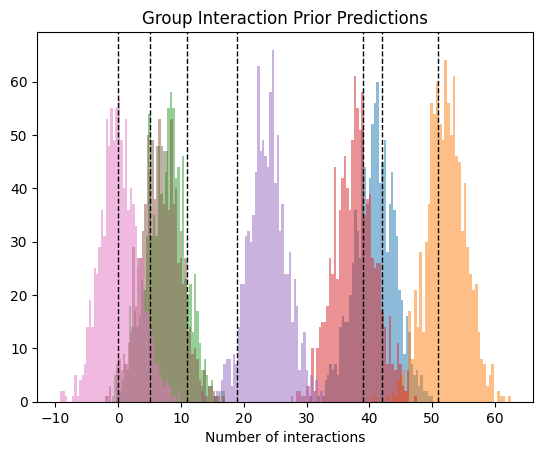

In [2]:
x_prior = x
print(x.shape)


for i in range(len(x_prior)):
    alpha = stats.truncnorm.rvs(.3,.7,loc=.5,scale=.1,size = 1)
    beta = stats.truncnorm.rvs(.9,1.1,loc=1,scale=.01,size = 1)
    sigma = stats.truncnorm.rvs(2,3,loc=2.5,scale=.25,size = 1)
    y_prior= np.random.normal(alpha + beta*x_prior[i], sigma,1000).flatten()
    
    plt.hist(y_prior, bins=50, alpha=0.5)
    plt.axvline(y[i], color='k', linestyle='dashed', linewidth=1)
    print("alpha: ", alpha)
    print("beta: ", beta)
    print("sigma: ", sigma)

plt.title('Group Interaction Prior Predictions')
plt.xlabel("Number of interactions")
plt.show()

In [37]:
prior_alpha = stats.truncnorm(.3,.7,loc=.5,scale=.1)
prior_beta = stats.truncnorm(.85,1.15,loc=1,scale=.05)
prior_sigma = stats.expon(2.5,.25)

def sim_prior():
    return np.array([prior_alpha.rvs(),
                     prior_beta.rvs(),
                     prior_sigma.rvs()])


In [38]:
prior_samples = []
num_repetitions = 1_000
for i in range(num_repetitions):
    [alpha, beta, sigma] = sim_prior()
    prior_samples.append([alpha,beta,sigma])
prior_samples = np.array(prior_samples)

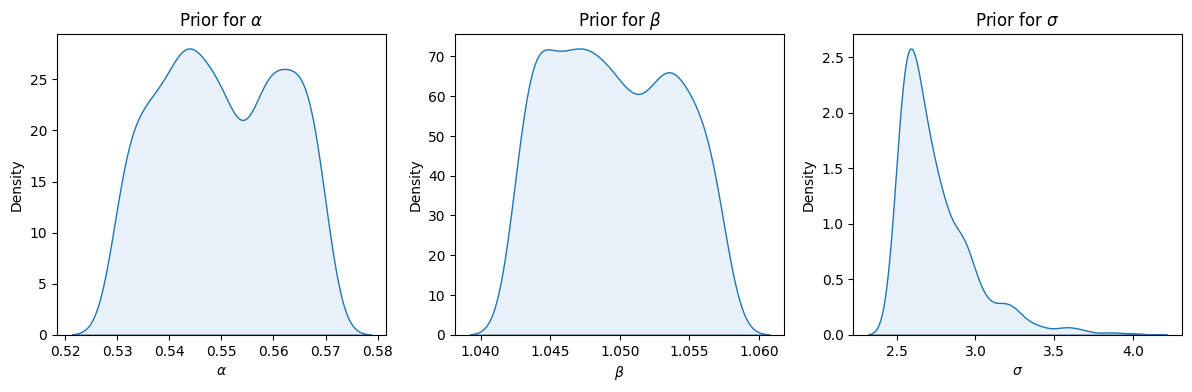

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title(r'Prior for $\alpha$')
sns.kdeplot(prior_samples[:,0],  fill=True, alpha=.1)
plt.xlabel(r'$\alpha$')

plt.subplot(132)
plt.title(r'Prior for $\beta$')
sns.kdeplot(prior_samples[:,1], clip=(0, 10), fill=True, alpha=.1)
plt.xlabel(r'$\beta$')

plt.subplot(133)
plt.title(r'Prior for $\sigma$')
sns.kdeplot(prior_samples[:,2], clip=(0, 10), fill=True, alpha=.1)
plt.xlabel(r'$\sigma$')

plt.tight_layout(pad=1)

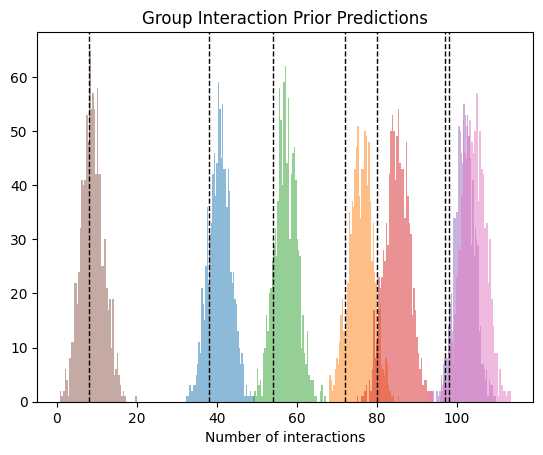

In [42]:
import random
x_dat = []
y_prior = []
for i in range(0,7):
    x_dat.append(random.randint(0,100))
x_dat = np.array(x_dat)
for i in range(len(x_dat)):
    [alpha, beta, sigma] = sim_prior()
    y_prior= np.random.normal(alpha + beta*x_dat[i], sigma,1000).flatten()
    
    plt.hist(y_prior, bins=50, alpha=0.5)
    plt.axvline(x_dat[i], color='k', linestyle='dashed', linewidth=1, label = "Previous Value")

plt.title('Group Interaction Prior Predictions')
plt.xlabel("Number of interactions")
#dashed line is the prev value


plt.show()



In [ ]:

# multinomial logit model for group interactions
num_groups = len(groups)
y = []
X = []

for user in users:
    y.append(user.interaction_history[-1])
    # every interaction but the last one
    X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))


X = pd.DataFrame(X)
X.fillna(0, inplace=True)

y = pd.DataFrame(y)
y = y.iloc[:,0]

# drop first column if sum is 0
if X.iloc[:,0].sum() == 0:
    X = X.iloc[:,1:]
    if num_groups != X.shape[1]:
        num_groups -= (X.shape[1] - num_groups)

for row in range(len(X)):
    X.iloc[row] = X.iloc[row] / X.iloc[row].sum()

X.fillna(0, inplace=True)
X = (X - X.mean()) / X.std()
X.fillna(0, inplace=True)


model = pm.Model()


with model:
    try:

        indices = pm.Data('index', list(range(len(X))), dims='user')
        # Define your data within the model
        X_data = pm.Data('X_data', X)
        y_data = pm.Data('y_data', y)

        # Model parameters
        
        alpha = pm.Exponential('alpha', lam=np.max(group_relative_frequency), shape=num_groups)

        beta_mu = pm.Normal('beta_mu', mu=1, sigma=10, shape=num_groups)
        beta_sd = pm.TruncatedNormal('beta_sd', lower=0, mu=5, sigma=2.5, shape=num_groups)

        beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sd, shape=(num_groups, num_groups))

        # Computing mu
        mu = alpha + pm.math.dot(X_data, beta) 

        # A numerically stable softmax
        mu_max = pm.math.max(mu, axis=1, keepdims=True)
        p = pm.Deterministic('p', pm.math.exp(mu - mu_max) / pm.math.sum(pm.math.exp(mu - mu_max), axis=1, keepdims=True))

        # Categorical distribution for observed data
        y_obs = pm.Categorical('y_obs', p=p, observed=y_data, dims='user')

        # Sampling
        trace = pm.sample(tune=5000, draws=5000)
        posterior_predictive = pm.sample_posterior_predictive(trace)
        prior_predictive = pm.sample_prior_predictive()

    except pm.exceptions.SamplingError:
        model.debug(verbose=True)


In [ ]:

print(az.summary(trace))

y_pred = np.rint(posterior_predictive['posterior_predictive']['y_obs'].mean(axis=(0,1))) 

plt.scatter(y, y_pred)
plt.xlabel('Actual Group ID')
plt.ylabel('Predicted Group ID')
plt.show()

plt.scatter(y, y_pred - y)
plt.xlabel('Actual Group ID')
plt.ylabel('Residual')
plt.show()

print(az.summary(trace))

plt.hist(y_pred, bins=num_groups, alpha=0.5, label='Predicted')
plt.hist(y,  bins=num_groups, alpha=0.5, label='Actual')
plt.legend(loc='upper right')
plt.xlabel("Group ID")
plt.ylabel("Frequency")
plt.show()
samples = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()
users = [[] for _ in range(samples.shape[2])]
for chain in range(samples.shape[0]):
  for draw in range(samples.shape[1]):
    for user in range(samples.shape[2]):
      users[user].append(samples[chain, draw, user])


# Define the grid layout
num_users = len(users)
num_rows = int(num_users**0.5)  # Number of rows in the grid
num_cols = (num_users + num_rows - 1) // num_rows  # Number of columns in the grid

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Iterate through users and plot histograms
for user_idx, ax in enumerate(axes.flat):
    if user_idx < num_users:
        user_data = users[user_idx]
        actual_interaction = y[user_idx]

        ax.hist(user_data, bins=num_groups)
        ax.axvline(actual_interaction, color='r', linestyle='dashed', linewidth=1)

        ax.set_title(f'User {user_idx + 1}')
        ax.set_xlabel('Interactions')
        ax.set_ylabel('Frequency')

# Remove any empty subplots
for user_idx in range(num_users, num_rows * num_cols):
    fig.delaxes(axes.flat[user_idx])

plt.tight_layout()
plt.show()